In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import datacleaning
import itertools
from nltk.probability import FreqDist
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
def do_centrality(G: nx.Graph):
    deg = pd.DataFrame(nx.degree_centrality(G).items(), columns=['Id', 'degree_centrality'])
    # eig = pd.DataFrame(nx.eigenvector_centrality_numpy(G, weight="Weight").items(), columns=['Id', 'eigenvector_centrality'])
    merged = pd.merge(data[['Id','title']], deg, on = "Id")
    return merged

data = pd.read_csv("data_small.csv")
data = data.rename(columns={"Unnamed: 0":"Id"})

In [3]:
graph_instruction = nx.read_gexf("recipe_instruction_small.gexf")
graph_ingredient = nx.read_gexf("recipe_ingredient_small.gexf")

graph_recipe_instruction_allwords = nx.read_gexf("recipe_instruction_nofilter.gexf")
graph_recipe_ingredient_allwords = nx.read_gexf("recipe_ingredient_nofilter.gexf")

graph_recipe_instruction_tfidf = nx.read_gexf("recipe_instruction_tfidf.gexf")
graph_recipe_ingredient_tfidf = nx.read_gexf("recipe_ingredient_tfidf.gexf")

graph_recipe_instruction_ranked_tfidf = nx.read_gexf("recipe_instruction_ranked_tfidf.gexf")
graph_recipe_ingredient_ranked_tfidf = nx.read_gexf("recipe_ingredient_ranked_tfidf.gexf")

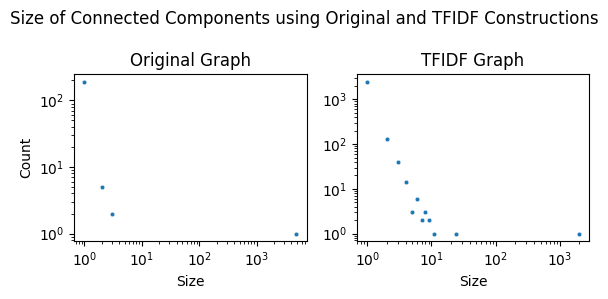

In [4]:
def count_components(G: nx.graph):
    graph_CCs = sorted(nx.connected_components(G), key=len, reverse=True)

    graph_CCs_subgraphs = [G.subgraph(c).copy() for c in graph_CCs]

    lens = [len(g) for g in graph_CCs_subgraphs]
    s, count = np.unique(np.sort(lens), return_counts=True)
    return np.asarray((s,count))

def plot_components(data, axes):
    a = sns.scatterplot(x = data[0], y = data[1], ax=axes, s=10)
    a.set_xscale('log')
    a.set_yscale('log')


plot_components(count_components(graph_ingredient), axes=axes[0])
plot_components(count_components(graph_recipe_ingredient_tfidf), axes=axes[1])
axes[0].set_title("Original Graph")
axes[1].set_title("TFIDF Graph")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Size")
axes[1].set_xlabel("Size")
fig.suptitle("Size of Connected Components using Original and TFIDF Constructions")

fig.tight_layout()
plt.savefig('figs/original_tfidf_components.pdf')

In [5]:
(do_centrality(graph_ingredient)).sort_values(by = 'degree_centrality', ascending = False)

,Id,title,degree_centrality
2507,UxpOTenDP2ohz10AFKIA.1XXWkwZdyK,Mrs. Sigg's Snickerdoodles,0.130626
3912,us79pWbQkannZMlUdpxJyhg3.hxsSeS,Blueberry Coffee Cake I,0.129826
148,9OMxs.iBBr1Quxb4odoRASv.cmxndGG,Honey's Butter Cake,0.125425
889,YxC.rYu4FeA1tGXTjg3CiyuB0J8EbiC,Cinnamon Hazelnut Biscotti,0.124425
3253,bCWMxEQcd/ftXTA0L1bBhDhweJi.ZaO,Country Morning Cake,0.121424
...,...,...,...
928,t5iXMdAf9E.ck5SNK8WlYmBIfGHMij2,Lemongrass Coconut Rice,0.000000
2601,svJB7iQO/DkckoyRVrIvuJVAtl6QKzy,Reddi-wip Filled Cupcakes,0.000000
2623,ynzgIQS1gZoz0uRV15CKmTPfsYRHFNe,Baked Ham with Maple Glaze,0.000000
4098,2YODNM4JSe5kpqCdpMfyjQ0mGGKD3hS,Kristy's Spicy Mustard,0.000000


In [6]:
(do_centrality(graph_instruction)).sort_values(by = 'degree_centrality', ascending = False)

,Id,title,degree_centrality
1123,Bp8g2s3Ki0yxGkT8XFNPc.BKJt/KbVO,Creamy Chicken and Broccoli Casserole,0.200040
4976,c/xFWXxvrZTrx0nun8d7yOvpOfEsG1C,Codfish with Cream,0.197840
1804,MQ1JOZdg6V9mhQoId99kdWC8mpjkE8u,Jambalaya with Fresh Fruit,0.194239
4916,O.HBaJ9715/EEl2S.uvHFpj5Hug3jsq,Jota (Bean and Sauerkraut Soup),0.193439
4810,WaTBd9K1j.3RkJuRZjJjroNR0AZFKGi,Estofado de Rabo de Toro (Spanish Oxtail Stew),0.192839
...,...,...,...
132,.Jyl/lO2xBVkx1lulw8t75VtHrf8u/a,Orange and Cinnamon Tequila Shot,0.000000
4945,1LqHZdGYqVUX9kx4N9HgFdpj.Z0SOVa,Mashed Potato Stuffed Cannoli,0.000000
4552,LFbRvboszaXN0z965g2lojriBmTSMMO,Non-Edible Cinnamon Dough,0.000000
4556,5s.4S6mTsQWRNXHDFGWe6ea03Oac48C,Momma's Marinara Sauce,0.000000


In [7]:
(do_centrality(graph_recipe_ingredient_tfidf)).sort_values(by = 'degree_centrality', ascending = False)


,Id,title,degree_centrality
4951,0Pc4kFAAjVKCTJzce6yOVVKYqmo/l7K,Busia's Cutout Cookies,0.037007
3968,m1Kmg9X88hoT3r./LqQj9ILdotobUym,Caramel Nut Cake in a Jar,0.035407
148,9OMxs.iBBr1Quxb4odoRASv.cmxndGG,Honey's Butter Cake,0.033207
1261,0N8YaXTjtaJo9E34qZ82dKhljwHfKpq,Chocolate Chip Cookies III,0.031806
1329,mWFUm.rybDWXkGH8E.d3D08CpXImN16,Happy Birthday Cake,0.028606
...,...,...,...
4978,ZbVNeKU6GLaQxqmL4sqx3dUSrvIhvTG,Strawberry Banana Blend,0.000000
4979,04k3Br06Nq0p888XqeqYzVgNOdODghi,Old-Fashioned Scalloped Corn,0.000000
4980,jkAP1QCljtgjEH.rCEghvOQ2JmG94tS,Spaghetti Torte,0.000000
4983,eyA3TPE.CuoJFX2W0ngRZ1oSyatMUPm,Gandule Rice,0.000000


In [8]:
graphs = [graph_ingredient, graph_instruction, graph_recipe_ingredient_allwords, graph_recipe_instruction_allwords, graph_recipe_ingredient_tfidf, graph_recipe_instruction_tfidf, graph_recipe_ingredient_ranked_tfidf, graph_recipe_instruction_ranked_tfidf]

In [9]:
graph_pairs = itertools.combinations(graphs, r=2)

In [53]:
import scipy
names = ["Original Ingredient", "Original Instruction", "All Ingredient Words", "All Instruction Words", "TFIDF Ingredient", "TFIDF Instruction", "Ranked TFIDF Ingredient", "Ranked TFIDF Instruction"]
graph_distance = pd.DataFrame(np.zeros(shape = (len(graphs), len(graphs))), columns=names)
graph_distance.insert(0, 'i', names)
graph_distance = graph_distance.set_index('i')
for i in range(len(graphs)):
    for j in range(len(graphs)):
        if i>j:
            graph_distance.iloc[i,j] = scipy.sparse.linalg.norm(nx.adjacency_matrix(graphs[i]) - nx.adjacency_matrix(graphs[j]))

#     for j in range(len(graphs)):
#         if i<j:
#             graph_distance[i,j] = 1
            # graph_distance[i,j] = 

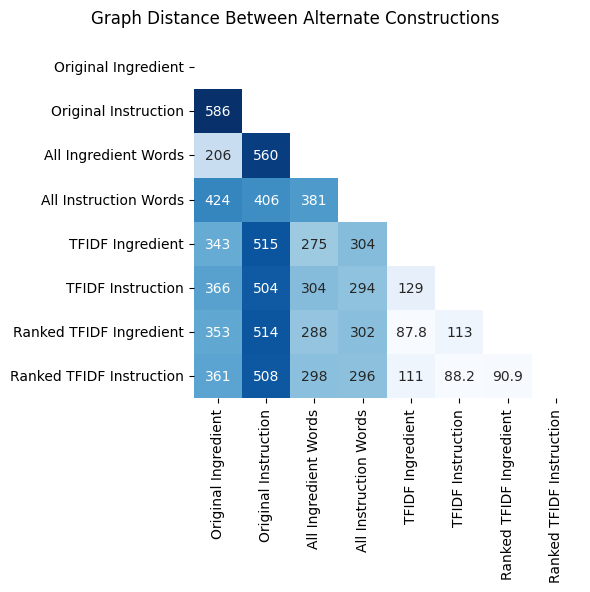

In [64]:
fig, ax = plt.subplots(1,1, figsize= (6,6), sharey=True)
a=sns.heatmap(graph_distance, annot=True, cmap="Blues", ax=ax, cbar = False, fmt='.3g', mask=(graph_distance==0))
a.set_ylabel("")
fig.suptitle("Graph Distance Between Alternate Constructions")
fig.tight_layout()
plt.savefig('figs/all_graphdistance.pdf')

